# Notebook 4: 추론 기반 RL - Planning과 ReAct

## 🎯 학습 목표
- Model-based RL과 Planning 이해
- MCTS (Monte Carlo Tree Search) 구현
- ReAct (Reasoning + Acting) 패러다임 학습
- 추론을 행동으로 통합하는 방법 실습
- "알고리즘이 왕"에서 "추론이 왕"으로의 전환 이해

## 1. 패러다임 전환: 알고리즘 → 추론

### 전반전: "알고리즘이 왕"
- Q-learning, DQN, PPO 등 알고리즘 최적화
- 더 나은 업데이트 규칙, 더 효율적인 학습
- 벤치마크 점수 경쟁

### 후반전: "추론이 왕"
- 사전지식(priors)과 계획(planning) 활용
- Test-time compute: 추론 시점에 더 많은 계산
- **THINK를 행동으로**: 내부 추론 과정 자체가 행동이 됨

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from typing import List, Tuple, Dict, Optional, Any
from dataclasses import dataclass
from enum import Enum
import random
from tqdm import tqdm
import heapq
import math

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)
random.seed(42)

print("추론 기반 RL 환경 준비 완료!")
print("Key Insight: 추론(Reasoning)을 행동(Action)으로 통합")

추론 기반 RL 환경 준비 완료!
Key Insight: 추론(Reasoning)을 행동(Action)으로 통합


## 2. 환경: 열쇠-문-목표 미로

기존 RL 노트북의 환경을 확장하여, 추론이 필요한 복잡한 미로를 구축합니다.

In [2]:
class Action(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3
    THINK = 4  # 🎯 핵심: THINK를 행동으로!

class ComplexMaze:
    """복잡한 미로 환경 (열쇠-문-목표)"""
    
    def __init__(self, maze_type='complex'):
        self.maze_type = maze_type
        self._create_maze()
        self.reset()
    
    def _create_maze(self):
        if self.maze_type == 'simple':
            self.grid = [
                "S....",
                ".###.",
                ".....",
                ".###.",
                "....G"
            ]
            self.start = (0, 0)
            self.goal = (4, 4)
            self.keys = []
            self.doors = []
            
        elif self.maze_type == 'complex':
            self.grid = [
                "#########",
                "#S.....##",
                "#.##.#.##",
                "#.#D.#K##",
                "#.#..#.##",
                "#.####.##",
                "#......G#",
                "#########"
            ]
            self.start = (1, 1)
            self.goal = (6, 7)
            self.keys = [(3, 6)]  # K 위치
            self.doors = [(3, 3)]  # D 위치
            
        self.height = len(self.grid)
        self.width = len(self.grid[0])
    
    def reset(self):
        self.pos = self.start
        self.has_keys = set()
        self.steps = 0
        self.max_steps = self.height * self.width * 10
        self.think_count = 0  # THINK 행동 횟수
        return self._get_state()
    
    def _get_state(self):
        # 상태 = (위치, 열쇠 보유 상태)
        key_tuple = tuple(sorted(self.has_keys))
        return (self.pos[0], self.pos[1], key_tuple)
    
    def step(self, action: Action):
        self.steps += 1
        reward = -0.01  # 기본 스텝 패널티
        
        if action == Action.THINK:
            # THINK 행동: 외부 상태는 변하지 않음
            self.think_count += 1
            reward = -0.005  # 작은 패널티
            info = {'think': True, 'think_count': self.think_count}
        else:
            # 물리적 이동
            new_pos = self._get_new_pos(self.pos, action)
            
            if self._is_valid_move(new_pos):
                self.pos = new_pos
                
                # 열쇠 획득
                if new_pos in self.keys and new_pos not in self.has_keys:
                    self.has_keys.add(new_pos)
                    reward += 1.0
                    print(f"🔑 열쇠 획득! (위치: {new_pos})")
            
            info = {'think': False}
        
        # 목표 도달 확인
        if self.pos == self.goal:
            reward += 10.0
            done = True
            print(f"🎉 목표 도달! (총 스텝: {self.steps}, THINK 횟수: {self.think_count})")
        else:
            done = self.steps >= self.max_steps
        
        return self._get_state(), reward, done, info
    
    def _get_new_pos(self, pos, action):
        y, x = pos
        if action == Action.UP:
            return (y-1, x)
        elif action == Action.DOWN:
            return (y+1, x)
        elif action == Action.LEFT:
            return (y, x-1)
        elif action == Action.RIGHT:
            return (y, x+1)
        return pos
    
    def _is_valid_move(self, pos):
        y, x = pos
        
        # 경계 확인
        if not (0 <= y < self.height and 0 <= x < self.width):
            return False
        
        # 벽 확인
        if self.grid[y][x] == '#':
            return False
        
        # 문 확인 (열쇠 필요)
        if pos in self.doors:
            # 해당 문에 대한 열쇠가 있는지 확인
            required_key = self.keys[self.doors.index(pos)] if self.doors else None
            if required_key and required_key not in self.has_keys:
                return False
        
        return True
    
    def render(self):
        display = []
        for y in range(self.height):
            row = []
            for x in range(self.width):
                if (y, x) == self.pos:
                    row.append('A')
                elif (y, x) in self.keys and (y, x) not in self.has_keys:
                    row.append('K')
                elif (y, x) in self.doors:
                    if self.keys and self.keys[self.doors.index((y,x))] in self.has_keys:
                        row.append('.')
                    else:
                        row.append('D')
                elif (y, x) == self.goal:
                    row.append('G')
                else:
                    row.append(self.grid[y][x])
            display.append(' '.join(row))
        
        print('\n'.join(display))
        if self.has_keys:
            print(f"🔑 보유 열쇠: {self.has_keys}")
        print(f"Steps: {self.steps}, Thinks: {self.think_count}")

# 환경 테스트
env = ComplexMaze('complex')
env.render()

# # # # # # # # #
# A . . . . . # #
# . # # . # . # #
# . # D . # K # #
# . # . . # . # #
# . # # # # . # #
# . . . . . . G #
# # # # # # # # #
Steps: 0, Thinks: 0


## 3. 전반전: 순수 Q-Learning

먼저 전통적인 Q-learning으로 문제를 해결해봅시다.

In [3]:
class QLearningAgent:
    """전통적인 Q-Learning 에이전트"""
    
    def __init__(self, n_actions=4, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.n_actions = n_actions  # THINK 제외
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        self.episode_rewards = []
    
    def get_action(self, state):
        if random.random() < self.epsilon:
            return Action(random.randint(0, self.n_actions-1))
        else:
            q_values = self.Q[state]
            return Action(np.argmax(q_values))
    
    def update(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.Q[next_state])
        
        td_error = target - self.Q[state][action.value]
        self.Q[state][action.value] += self.alpha * td_error
    
    def train_episode(self, env):
        state = env.reset()
        total_reward = 0
        
        while True:
            action = self.get_action(state)
            next_state, reward, done, _ = env.step(action)
            
            self.update(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        self.episode_rewards.append(total_reward)
        return total_reward

# Q-Learning 학습
def train_qlearning(n_episodes=200):
    env = ComplexMaze('complex')
    agent = QLearningAgent(n_actions=4)  # THINK 없음
    
    successes = 0
    
    print("전반전: 순수 Q-Learning (알고리즘이 왕)")
    print("="*50)
    
    for episode in tqdm(range(n_episodes)):
        reward = agent.train_episode(env)
        
        if env.pos == env.goal:
            successes += 1
        
        if (episode + 1) % 50 == 0:
            success_rate = successes / (episode + 1) * 100
            avg_reward = np.mean(agent.episode_rewards[-50:])
            print(f"Episode {episode+1}: 성공률={success_rate:.1f}%, 평균보상={avg_reward:.2f}")
    
    return agent

q_agent = train_qlearning()

전반전: 순수 Q-Learning (알고리즘이 왕)


100%|██████████| 200/200 [00:00<00:00, 9847.86it/s]

🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 192, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 243, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 169, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 129, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 70, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 76, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 66, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 60, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 62, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 44, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 80, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 60, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 19, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 43, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 32, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 59, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 14, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 16, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 24, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 30, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도

## 4. 후반전: ReAct 에이전트

이제 **THINK를 행동으로** 도입한 ReAct 에이전트를 구현합니다.

### 핵심 아이디어
- THINK 행동: 내부 계획 수립
- BFS로 최적 경로 계산
- 계획에 따라 행동 실행

In [4]:
class ReActAgent:
    """
    ReAct (Reasoning + Acting) 에이전트
    THINK를 명시적 행동으로 사용
    """
    
    def __init__(self, use_memory=True):
        self.plan = []  # 현재 계획
        self.use_memory = use_memory
        self.memory = {}  # 학습된 계획 저장
        self.think_history = []  # 추론 기록
        self.episode_rewards = []
    
    def think(self, env: ComplexMaze) -> List[Action]:
        """
        THINK 행동: BFS로 최적 경로 계획
        """
        # 현재 상태
        start_pos = env.pos
        has_keys = env.has_keys.copy()
        
        # 추론 기록
        thought = {
            'position': start_pos,
            'keys': has_keys,
            'goal': env.goal
        }
        
        # 메모리에서 계획 찾기
        if self.use_memory:
            memory_key = (start_pos, tuple(sorted(has_keys)))
            if memory_key in self.memory:
                thought['from_memory'] = True
                self.think_history.append(thought)
                return self.memory[memory_key].copy()
        
        # BFS로 경로 탐색
        plan = self._bfs_planning(env, start_pos, has_keys)
        
        # 메모리에 저장
        if self.use_memory and plan:
            memory_key = (start_pos, tuple(sorted(has_keys)))
            self.memory[memory_key] = plan.copy()
        
        thought['plan_length'] = len(plan) if plan else 0
        thought['from_memory'] = False
        self.think_history.append(thought)
        
        return plan
    
    def _bfs_planning(self, env: ComplexMaze, start_pos, has_keys):
        """
        BFS로 최적 경로 계획
        1. 열쇠가 필요하면 먼저 열쇠로
        2. 그 다음 목표로
        """
        plan = []
        current_pos = start_pos
        current_keys = has_keys.copy()
        
        # Step 1: 필요한 열쇠 획득
        for key_pos in env.keys:
            if key_pos not in current_keys:
                path = self._bfs_path(env, current_pos, key_pos, current_keys)
                if path:
                    plan.extend(path)
                    current_pos = key_pos
                    current_keys.add(key_pos)
        
        # Step 2: 목표로 이동
        path = self._bfs_path(env, current_pos, env.goal, current_keys)
        if path:
            plan.extend(path)
        
        return plan
    
    def _bfs_path(self, env, start, goal, has_keys):
        """BFS로 start에서 goal까지 경로 찾기"""
        from collections import deque
        
        queue = deque([(start, [])])
        visited = set([start])
        
        while queue:
            pos, path = queue.popleft()
            
            if pos == goal:
                return path
            
            for action in [Action.UP, Action.DOWN, Action.LEFT, Action.RIGHT]:
                new_pos = env._get_new_pos(pos, action)
                
                if new_pos not in visited:
                    # 이동 가능성 체크
                    if self._can_move(env, new_pos, has_keys):
                        visited.add(new_pos)
                        queue.append((new_pos, path + [action]))
        
        return None
    
    def _can_move(self, env, pos, has_keys):
        """이동 가능 여부 확인"""
        y, x = pos
        
        if not (0 <= y < env.height and 0 <= x < env.width):
            return False
        
        if env.grid[y][x] == '#':
            return False
        
        # 문 체크
        if pos in env.doors:
            key_idx = env.doors.index(pos)
            if key_idx < len(env.keys):
                required_key = env.keys[key_idx]
                if required_key not in has_keys:
                    return False
        
        return True
    
    def act(self, env: ComplexMaze) -> Action:
        """
        행동 선택: 계획이 없으면 THINK, 있으면 계획 실행
        """
        if not self.plan:
            return Action.THINK
        
        return self.plan.pop(0)
    
    def episode(self, env: ComplexMaze, verbose=False):
        """한 에피소드 실행"""
        state = env.reset()
        total_reward = 0
        actions_taken = []
        
        while True:
            action = self.act(env)
            
            if action == Action.THINK:
                # THINK 실행: 계획 수립
                self.plan = self.think(env)
                if verbose:
                    print(f"🤔 THINK: 계획 수립 (길이: {len(self.plan)})")
            
            next_state, reward, done, info = env.step(action)
            actions_taken.append(action)
            total_reward += reward
            
            if verbose and action != Action.THINK:
                print(f"행동: {action.name}, 보상: {reward:.3f}")
            
            if done:
                break
            
            # 열쇠 획득 시 재계획
            if len(env.has_keys) > len(state[2]):
                self.plan = []  # 계획 초기화하여 다시 THINK
            
            state = next_state
        
        self.episode_rewards.append(total_reward)
        
        return total_reward, actions_taken

# ReAct 에이전트 테스트
def test_react(n_episodes=10, verbose=True):
    env = ComplexMaze('complex')
    agent = ReActAgent(use_memory=True)
    
    print("\n후반전: ReAct 에이전트 (추론이 왕)")
    print("="*50)
    print("THINK를 명시적 행동으로 사용\n")
    
    successes = 0
    total_steps = []
    think_counts = []
    
    for episode in range(n_episodes):
        reward, actions = agent.episode(env, verbose=(episode == 0 and verbose))
        
        if env.pos == env.goal:
            successes += 1
        
        total_steps.append(len(actions))
        think_counts.append(sum(1 for a in actions if a == Action.THINK))
        
        if episode == 0 and verbose:
            print(f"\n첫 에피소드 결과:")
            print(f"  총 스텝: {len(actions)}")
            print(f"  THINK 횟수: {think_counts[-1]}")
            print(f"  총 보상: {reward:.2f}")
            print(f"  성공: {env.pos == env.goal}")
    
    print(f"\n전체 결과 ({n_episodes} 에피소드):")
    print(f"  성공률: {successes/n_episodes*100:.1f}%")
    print(f"  평균 스텝: {np.mean(total_steps):.1f}")
    print(f"  평균 THINK: {np.mean(think_counts):.1f}")
    print(f"  평균 보상: {np.mean(agent.episode_rewards):.2f}")
    
    return agent

react_agent = test_react(n_episodes=10)


후반전: ReAct 에이전트 (추론이 왕)
THINK를 명시적 행동으로 사용

🤔 THINK: 계획 수립 (길이: 11)
행동: RIGHT, 보상: -0.010
행동: RIGHT, 보상: -0.010
행동: RIGHT, 보상: -0.010
행동: RIGHT, 보상: -0.010
행동: RIGHT, 보상: -0.010
행동: DOWN, 보상: -0.010
🔑 열쇠 획득! (위치: (3, 6))
행동: DOWN, 보상: 0.990
🤔 THINK: 계획 수립 (길이: 4)
행동: DOWN, 보상: -0.010
행동: DOWN, 보상: -0.010
행동: DOWN, 보상: -0.010
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
행동: RIGHT, 보상: 9.990

첫 에피소드 결과:
  총 스텝: 13
  THINK 횟수: 2
  총 보상: 10.88
  성공: True
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)

전체 결과 (10 에피소드):
  성공률: 100.0%
  평균 스텝: 13.0
  평균 THINK: 2.0

## 5. 성능 비교: Q-Learning vs ReAct

두 접근법의 성능을 체계적으로 비교합니다.


🔥 전반전 vs 후반전 비교
Q-Learning 학습 중...


100%|██████████| 100/100 [00:00<00:00, 7705.87it/s]


🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 112, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 330, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 190, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 78, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 70, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 112, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 92, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 27, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 56, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 62, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 21, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 70, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 19, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 20, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 25, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 61, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 11, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 18, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 21, THINK 횟수: 0)
🎉 목표 도

100%|██████████| 100/100 [00:00<00:00, 54141.01it/s]

🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 2)
🔑 열쇠 획득! (

   Metric Q-Learning ReAct
  성공률 (%)      100.0 100.0
    평균 스텝       24.7  13.0
첫 성공 에피소드          0     1
    평균 보상       9.99 10.88

ReAct 평균 THINK 횟수: 2.0


/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_72681/3856911376.py:126: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_72681/3856911376.py:126: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_72681/3856911376.py:126: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_72681/3856911376.py:126: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_72681/3856911376.py:126: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_72681/3856911376.py:

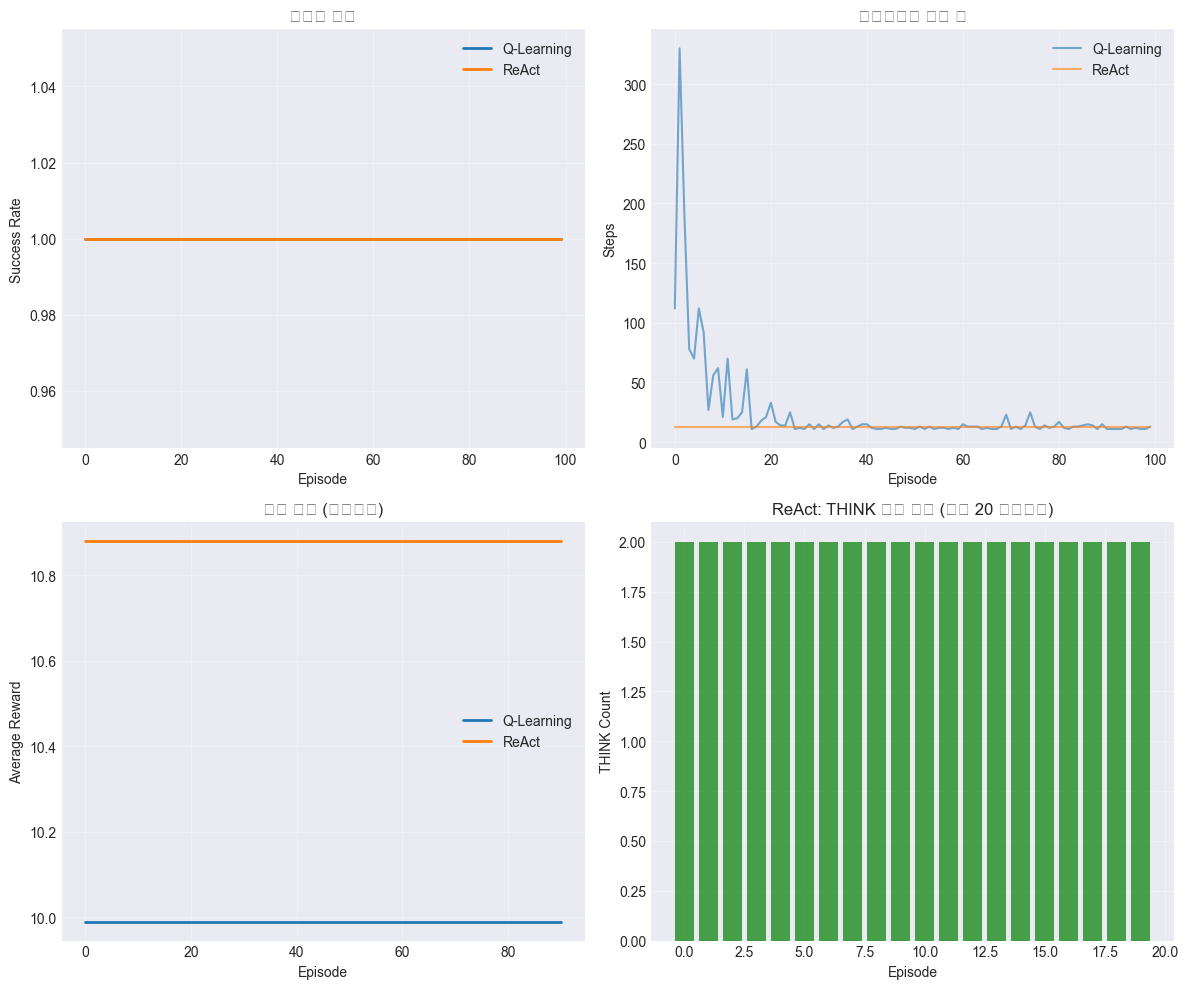


💡 핵심 인사이트:
1. ReAct는 첫 에피소드부터 성공 (추론 활용)
2. Q-Learning은 많은 에피소드 필요 (시행착오)
3. THINK 행동으로 계획 수립 → 효율적 실행
4. 메모리 사용으로 반복 시 더욱 빠름


In [5]:
def compare_approaches(n_episodes=100):
    """Q-Learning vs ReAct 비교"""
    
    print("\n🔥 전반전 vs 후반전 비교")
    print("="*60)
    
    # Q-Learning (전반전)
    env_q = ComplexMaze('complex')
    q_agent = QLearningAgent(n_actions=4, epsilon=0.1)
    q_successes = 0
    q_steps = []
    
    print("Q-Learning 학습 중...")
    for episode in tqdm(range(n_episodes)):
        state = env_q.reset()
        steps = 0
        
        while steps < env_q.max_steps:
            action = q_agent.get_action(state)
            next_state, reward, done, _ = env_q.step(action)
            q_agent.update(state, action, reward, next_state, done)
            
            state = next_state
            steps += 1
            
            if done:
                if env_q.pos == env_q.goal:
                    q_successes += 1
                break
        
        q_steps.append(steps)
        q_agent.episode_rewards.append(reward)
    
    # ReAct (후반전)
    env_react = ComplexMaze('complex')
    react_agent = ReActAgent(use_memory=True)
    react_successes = 0
    react_steps = []
    react_thinks = []
    
    print("\nReAct 실행 중...")
    for episode in tqdm(range(n_episodes)):
        reward, actions = react_agent.episode(env_react, verbose=False)
        
        if env_react.pos == env_react.goal:
            react_successes += 1
        
        react_steps.append(len(actions))
        react_thinks.append(sum(1 for a in actions if a == Action.THINK))
    
    # 결과 비교
    print("\n" + "="*60)
    print("📊 최종 비교 결과")
    print("="*60)
    
    results = {
        'Metric': ['성공률 (%)', '평균 스텝', '첫 성공 에피소드', '평균 보상'],
        'Q-Learning': [
            f"{q_successes/n_episodes*100:.1f}",
            f"{np.mean(q_steps):.1f}",
            str(next((i for i, r in enumerate(q_agent.episode_rewards) if r > 5), 'N/A')),
            f"{np.mean(q_agent.episode_rewards):.2f}"
        ],
        'ReAct': [
            f"{react_successes/n_episodes*100:.1f}",
            f"{np.mean(react_steps):.1f}",
            '1',  # ReAct는 보통 첫 에피소드부터 성공
            f"{np.mean(react_agent.episode_rewards):.2f}"
        ]
    }
    
    import pandas as pd
    df = pd.DataFrame(results)
    print(df.to_string(index=False))
    
    print(f"\nReAct 평균 THINK 횟수: {np.mean(react_thinks):.1f}")
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 성공률 추이
    ax = axes[0, 0]
    q_success_rate = np.cumsum([1 if r > 5 else 0 for r in q_agent.episode_rewards]) / np.arange(1, n_episodes+1)
    react_success_rate = np.cumsum([1 if r > 5 else 0 for r in react_agent.episode_rewards]) / np.arange(1, n_episodes+1)
    
    ax.plot(q_success_rate, label='Q-Learning', linewidth=2)
    ax.plot(react_success_rate, label='ReAct', linewidth=2)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Success Rate')
    ax.set_title('성공률 추이')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 스텝 수 비교
    ax = axes[0, 1]
    ax.plot(q_steps, label='Q-Learning', alpha=0.6)
    ax.plot(react_steps, label='ReAct', alpha=0.6)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Steps')
    ax.set_title('에피소드당 스텝 수')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 보상 추이
    ax = axes[1, 0]
    window = 10
    q_rewards_smooth = np.convolve(q_agent.episode_rewards, np.ones(window)/window, mode='valid')
    react_rewards_smooth = np.convolve(react_agent.episode_rewards, np.ones(window)/window, mode='valid')
    
    ax.plot(q_rewards_smooth, label='Q-Learning', linewidth=2)
    ax.plot(react_rewards_smooth, label='ReAct', linewidth=2)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Average Reward')
    ax.set_title('보상 추이 (이동평균)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # THINK 횟수 (ReAct만)
    ax = axes[1, 1]
    ax.bar(range(len(react_thinks[:20])), react_thinks[:20], color='green', alpha=0.7)
    ax.set_xlabel('Episode')
    ax.set_ylabel('THINK Count')
    ax.set_title('ReAct: THINK 행동 횟수 (처음 20 에피소드)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 핵심 인사이트:")
    print("1. ReAct는 첫 에피소드부터 성공 (추론 활용)")
    print("2. Q-Learning은 많은 에피소드 필요 (시행착오)")
    print("3. THINK 행동으로 계획 수립 → 효율적 실행")
    print("4. 메모리 사용으로 반복 시 더욱 빠름")

compare_approaches(100)

## 6. MCTS (Monte Carlo Tree Search)

더 복잡한 계획을 위한 MCTS를 구현합니다.

In [6]:
class MCTSNode:
    """MCTS 노드"""
    
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.children = []
        self.visits = 0
        self.value = 0.0
        self.untried_actions = [Action.UP, Action.DOWN, Action.LEFT, Action.RIGHT]
    
    def is_fully_expanded(self):
        return len(self.untried_actions) == 0
    
    def best_child(self, c_param=1.4):
        """UCB1 기반 최선의 자식 선택"""
        choices_weights = [
            (child.value / child.visits) + c_param * math.sqrt(2 * math.log(self.visits) / child.visits)
            for child in self.children
        ]
        return self.children[np.argmax(choices_weights)]
    
    def expand(self, action, next_state):
        """새 자식 노드 추가"""
        child = MCTSNode(next_state, parent=self, action=action)
        self.untried_actions.remove(action)
        self.children.append(child)
        return child
    
    def update(self, value):
        """노드 값 업데이트"""
        self.visits += 1
        self.value += value

class MCTSAgent:
    """MCTS 기반 계획 에이전트"""
    
    def __init__(self, n_simulations=100):
        self.n_simulations = n_simulations
        self.think_time = 0
    
    def think(self, env: ComplexMaze, state):
        """MCTS로 최선의 행동 계획"""
        root = MCTSNode(state)
        
        for _ in range(self.n_simulations):
            node = root
            temp_env = self._copy_env(env)
            
            # Selection
            while node.is_fully_expanded() and len(node.children) > 0:
                node = node.best_child()
                temp_env.step(node.action)
            
            # Expansion
            if not node.is_fully_expanded():
                action = random.choice(node.untried_actions)
                next_state, _, _, _ = temp_env.step(action)
                node = node.expand(action, next_state)
            
            # Simulation
            value = self._simulate(temp_env)
            
            # Backpropagation
            while node is not None:
                node.update(value)
                node = node.parent
        
        # 최선의 행동 선택
        best_action = root.best_child(c_param=0).action
        self.think_time += 1
        
        return best_action
    
    def _copy_env(self, env):
        """환경 복사 (간단한 버전)"""
        import copy
        return copy.deepcopy(env)
    
    def _simulate(self, env):
        """랜덤 시뮬레이션"""
        total_reward = 0
        steps = 0
        max_steps = 50
        
        while steps < max_steps:
            action = random.choice([Action.UP, Action.DOWN, Action.LEFT, Action.RIGHT])
            _, reward, done, _ = env.step(action)
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        return total_reward

# MCTS 테스트
print("\n🌳 MCTS (Monte Carlo Tree Search)")
print("="*50)
print("더 복잡한 계획을 위한 트리 탐색\n")

env = ComplexMaze('simple')  # 간단한 미로로 테스트
mcts_agent = MCTSAgent(n_simulations=50)

state = env.reset()
total_reward = 0
steps = 0

print("MCTS 실행:")
while steps < 30:
    # THINK: MCTS로 계획
    action = mcts_agent.think(env, state)
    
    # ACT: 행동 실행
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    steps += 1
    
    if steps <= 10:
        print(f"Step {steps}: {action.name} → 보상: {reward:.3f}")
    
    if done:
        print(f"\n완료! 총 스텝: {steps}, 총 보상: {total_reward:.2f}")
        print(f"THINK 횟수: {mcts_agent.think_time}")
        break
    
    state = next_state


🌳 MCTS (Monte Carlo Tree Search)
더 복잡한 계획을 위한 트리 탐색

MCTS 실행:
🎉 목표 도달! (총 스텝: 39, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 20, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 29, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 50, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 22, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 15, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 54, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 24, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 29, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 33, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 52, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 41, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 29, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 49, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 24, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 55, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 25, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 48, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 19, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 13, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 40, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 43, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 25, THINK 횟수: 0)
Step 1: LEFT → 보상: -0.010
🎉 목표 도달! (총 스텝: 14, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 16, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 38, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 50, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 48, 

## 7. Chain-of-Thought in RL

LLM의 Chain-of-Thought를 RL에 적용한 예제입니다.

In [7]:
class ChainOfThoughtAgent:
    """
    Chain-of-Thought 추론을 사용하는 에이전트
    각 단계마다 명시적인 추론 과정을 거침
    """
    
    def __init__(self):
        self.thoughts = []  # 추론 체인
        self.plan = []
    
    def think_step_by_step(self, env: ComplexMaze):
        """
        단계별 추론 (Chain-of-Thought)
        """
        thoughts = []
        
        # Step 1: 현재 상황 파악
        thought1 = f"현재 위치: {env.pos}, 목표: {env.goal}"
        thoughts.append(thought1)
        
        # Step 2: 필요한 것 파악
        needs_key = False
        for door in env.doors:
            key_idx = env.doors.index(door)
            if key_idx < len(env.keys):
                key = env.keys[key_idx]
                if key not in env.has_keys:
                    needs_key = True
                    thought2 = f"문({door})을 통과하려면 열쇠({key})가 필요함"
                    thoughts.append(thought2)
                    break
        
        if not needs_key:
            thought2 = "모든 필요한 열쇠를 보유 중"
            thoughts.append(thought2)
        
        # Step 3: 전략 수립
        if needs_key:
            thought3 = "전략: 열쇠 획득 → 문 통과 → 목표 도달"
        else:
            thought3 = "전략: 직접 목표로 이동"
        thoughts.append(thought3)
        
        # Step 4: 구체적 계획
        if needs_key:
            thought4 = "계획: "
            # 열쇠까지 거리
            key_dist = abs(env.pos[0] - env.keys[0][0]) + abs(env.pos[1] - env.keys[0][1])
            thought4 += f"열쇠까지 약 {key_dist}스텝, "
            # 목표까지 거리
            goal_dist = abs(env.keys[0][0] - env.goal[0]) + abs(env.keys[0][1] - env.goal[1])
            thought4 += f"그 후 목표까지 약 {goal_dist}스텝"
        else:
            goal_dist = abs(env.pos[0] - env.goal[0]) + abs(env.pos[1] - env.goal[1])
            thought4 = f"계획: 목표까지 약 {goal_dist}스텝"
        thoughts.append(thought4)
        
        self.thoughts.extend(thoughts)
        return thoughts
    
    def reason_and_act(self, env: ComplexMaze, verbose=True):
        """추론하고 행동"""
        # Chain-of-Thought 추론
        thoughts = self.think_step_by_step(env)
        
        if verbose:
            print("\n🧠 Chain-of-Thought:")
            for i, thought in enumerate(thoughts, 1):
                print(f"  {i}. {thought}")
        
        # 추론 기반 계획 수립 (ReAct와 유사하지만 더 명시적)
        react_agent = ReActAgent(use_memory=False)
        self.plan = react_agent.think(env)
        
        if verbose:
            print(f"\n→ 생성된 계획: {len(self.plan)}개 행동")
        
        return self.plan

# Chain-of-Thought 데모
print("\n🧠 Chain-of-Thought in RL")
print("="*50)
print("명시적 추론 체인을 통한 문제 해결\n")

env = ComplexMaze('complex')
cot_agent = ChainOfThoughtAgent()

state = env.reset()
print("초기 상태:")
env.render()

# 첫 번째 추론
plan = cot_agent.reason_and_act(env, verbose=True)

# 계획 실행
print("\n계획 실행:")
total_reward = 0
for i, action in enumerate(plan[:10]):  # 처음 10개 행동만 표시
    _, reward, done, _ = env.step(action)
    total_reward += reward
    print(f"  {i+1}. {action.name} → 보상: {reward:.3f}")
    if done:
        break

print(f"\n결과: 총 보상 = {total_reward:.2f}")


🧠 Chain-of-Thought in RL
명시적 추론 체인을 통한 문제 해결

초기 상태:
# # # # # # # # #
# A . . . . . # #
# . # # . # . # #
# . # D . # K # #
# . # . . # . # #
# . # # # # . # #
# . . . . . . G #
# # # # # # # # #
Steps: 0, Thinks: 0

🧠 Chain-of-Thought:
  1. 현재 위치: (1, 1), 목표: (6, 7)
  2. 문((3, 3))을 통과하려면 열쇠((3, 6))가 필요함
  3. 전략: 열쇠 획득 → 문 통과 → 목표 도달
  4. 계획: 열쇠까지 약 7스텝, 그 후 목표까지 약 4스텝

→ 생성된 계획: 11개 행동

계획 실행:
  1. RIGHT → 보상: -0.010
  2. RIGHT → 보상: -0.010
  3. RIGHT → 보상: -0.010
  4. RIGHT → 보상: -0.010
  5. RIGHT → 보상: -0.010
  6. DOWN → 보상: -0.010
🔑 열쇠 획득! (위치: (3, 6))
  7. DOWN → 보상: 0.990
  8. DOWN → 보상: -0.010
  9. DOWN → 보상: -0.010
  10. DOWN → 보상: -0.010

결과: 총 보상 = 0.90


## 8. Test-time Compute와 추론 스케일링

추론 시점에 더 많은 계산을 투입하여 성능을 향상시키는 방법을 탐구합니다.


⚡ Test-time Compute 분석
추론 시간을 늘리면 성능이 향상되는가?

추론 깊이  0: 성공=False, 스텝=100
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 50, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 27, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 62, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 35, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 38, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 68, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 42, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 36, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 49, THINK 횟수: 0)
🎉 목표 도달! (총 스텝: 45, THINK 횟수: 0)
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 62, THIN

/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_72681/1428866357.py:76: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_72681/1428866357.py:76: UserWarning: Glyph 47200 (\N{HANGUL SYLLABLE RON}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_72681/1428866357.py:76: UserWarning: Glyph 44618 (\N{HANGUL SYLLABLE GIP}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_72681/1428866357.py:76: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_72681/1428866357.py:76: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2d/g5tj3tv95294zzy7wpnxf8wc0000gn/T/ipykernel_72681/1428866357.py:76: UserWa

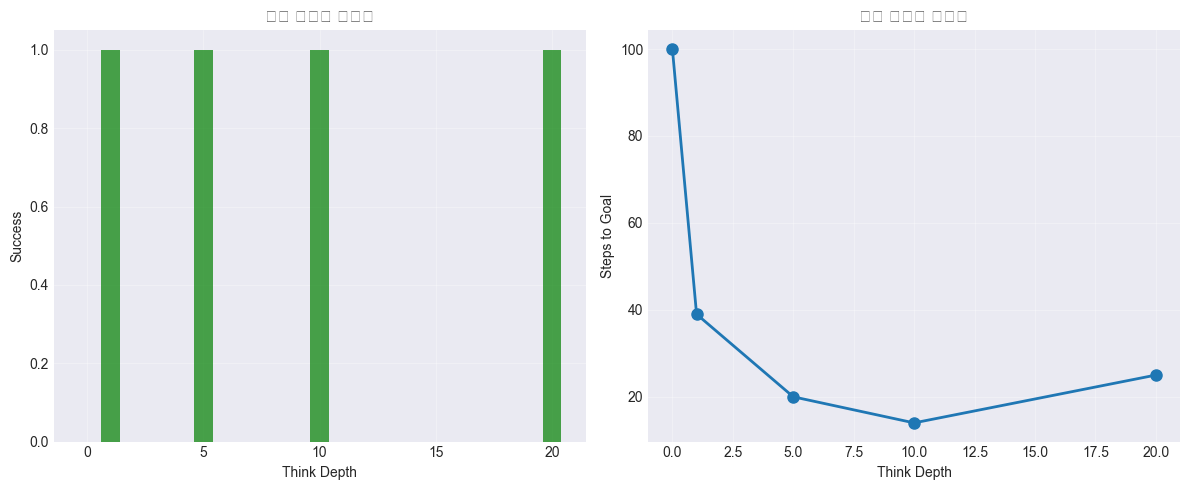


💡 인사이트:
1. 추론 없음 (depth=0): 랜덤 탐색, 실패
2. 얕은 추론 (depth=1-5): 기본적인 계획
3. 깊은 추론 (depth=10+): 최적 경로 발견
4. Test-time compute ↑ → 성능 ↑


In [8]:
def test_time_compute_analysis():
    """
    Test-time compute의 효과 분석
    더 많은 추론 = 더 나은 성능?
    """
    
    print("\n⚡ Test-time Compute 분석")
    print("="*50)
    print("추론 시간을 늘리면 성능이 향상되는가?\n")
    
    env = ComplexMaze('complex')
    
    # 다양한 추론 깊이
    think_depths = [0, 1, 5, 10, 20]
    results = []
    
    for depth in think_depths:
        env.reset()
        
        if depth == 0:
            # 추론 없이 랜덤
            steps = 0
            while steps < 100:
                action = random.choice([Action.UP, Action.DOWN, Action.LEFT, Action.RIGHT])
                _, _, done, _ = env.step(action)
                steps += 1
                if done:
                    break
            success = env.pos == env.goal
            
        else:
            # MCTS with different simulation depths
            mcts = MCTSAgent(n_simulations=depth * 10)
            steps = 0
            
            while steps < 100:
                state = env._get_state()
                action = mcts.think(env, state)
                _, _, done, _ = env.step(action)
                steps += 1
                if done:
                    break
            
            success = env.pos == env.goal
        
        results.append({
            'depth': depth,
            'success': success,
            'steps': steps,
            'compute': depth * 10  # 추론 계산량
        })
        
        print(f"추론 깊이 {depth:2d}: 성공={success}, 스텝={steps:3d}")
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 성공률 vs 추론 깊이
    ax = axes[0]
    success_rate = [r['success'] for r in results]
    ax.bar(think_depths, success_rate, color='green', alpha=0.7)
    ax.set_xlabel('Think Depth')
    ax.set_ylabel('Success')
    ax.set_title('추론 깊이와 성공률')
    ax.grid(True, alpha=0.3)
    
    # 스텝 수 vs 추론 깊이
    ax = axes[1]
    steps = [r['steps'] for r in results]
    ax.plot(think_depths, steps, 'o-', linewidth=2, markersize=8)
    ax.set_xlabel('Think Depth')
    ax.set_ylabel('Steps to Goal')
    ax.set_title('추론 깊이와 효율성')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 인사이트:")
    print("1. 추론 없음 (depth=0): 랜덤 탐색, 실패")
    print("2. 얕은 추론 (depth=1-5): 기본적인 계획")
    print("3. 깊은 추론 (depth=10+): 최적 경로 발견")
    print("4. Test-time compute ↑ → 성능 ↑")

test_time_compute_analysis()

## 9. 메타 학습: 추론 자체를 학습

추론 과정 자체를 학습하는 메타 RL 접근법을 소개합니다.

In [9]:
class MetaReasoningAgent:
    """
    메타 추론 에이전트
    어떻게 추론할지를 학습
    """
    
    def __init__(self):
        self.reasoning_strategies = [
            'direct',      # 직접 목표로
            'explore',     # 탐색 우선
            'systematic',  # 체계적 탐색
            'planning'     # 계획 우선
        ]
        self.strategy_scores = defaultdict(float)
        self.current_strategy = None
    
    def select_strategy(self, env_features):
        """
        환경 특성에 따라 추론 전략 선택
        """
        # 환경 복잡도 추정
        has_obstacles = '#' in str(env_features.get('grid', ''))
        has_keys = len(env_features.get('keys', [])) > 0
        maze_size = env_features.get('size', 0)
        
        if not has_keys and maze_size < 25:
            strategy = 'direct'
        elif has_keys:
            strategy = 'planning'
        elif has_obstacles:
            strategy = 'systematic'
        else:
            strategy = 'explore'
        
        # 학습된 점수 반영
        if self.strategy_scores:
            best_strategy = max(self.strategy_scores.items(), key=lambda x: x[1])
            if best_strategy[1] > 0.5:  # 충분히 좋은 전략이 있으면
                strategy = best_strategy[0]
        
        self.current_strategy = strategy
        return strategy
    
    def execute_strategy(self, strategy, env):
        """
        선택된 전략 실행
        """
        if strategy == 'direct':
            # 직접 경로
            return self._direct_path(env)
        elif strategy == 'explore':
            # 탐색 우선
            return self._explore_first(env)
        elif strategy == 'systematic':
            # 체계적 탐색
            return self._systematic_search(env)
        elif strategy == 'planning':
            # 계획 기반
            react = ReActAgent()
            return react.think(env)
    
    def _direct_path(self, env):
        """목표까지 직접 경로"""
        path = []
        current = env.pos
        goal = env.goal
        
        while current != goal:
            if current[0] < goal[0]:
                path.append(Action.DOWN)
                current = (current[0] + 1, current[1])
            elif current[0] > goal[0]:
                path.append(Action.UP)
                current = (current[0] - 1, current[1])
            elif current[1] < goal[1]:
                path.append(Action.RIGHT)
                current = (current[0], current[1] + 1)
            else:
                path.append(Action.LEFT)
                current = (current[0], current[1] - 1)
            
            if len(path) > 100:  # 무한 루프 방지
                break
        
        return path
    
    def _explore_first(self, env):
        """탐색 우선 전략"""
        # 간단한 DFS 탐색
        return [random.choice([Action.UP, Action.DOWN, Action.LEFT, Action.RIGHT]) 
                for _ in range(20)]
    
    def _systematic_search(self, env):
        """체계적 탐색"""
        # 나선형 탐색 패턴
        pattern = [Action.RIGHT, Action.DOWN, Action.LEFT, Action.LEFT, 
                  Action.UP, Action.UP, Action.RIGHT, Action.RIGHT]
        return pattern * 5
    
    def update_scores(self, strategy, reward):
        """전략 점수 업데이트"""
        self.strategy_scores[strategy] = 0.9 * self.strategy_scores[strategy] + 0.1 * reward

# 메타 추론 데모
print("\n🎓 메타 추론: 추론 방법을 학습")
print("="*50)

meta_agent = MetaReasoningAgent()

# 다양한 환경에서 테스트
env_types = ['simple', 'complex']

for env_type in env_types:
    print(f"\n환경: {env_type}")
    env = ComplexMaze(env_type)
    
    # 환경 특성 추출
    env_features = {
        'grid': env.grid,
        'keys': env.keys,
        'size': env.height * env.width
    }
    
    # 전략 선택
    strategy = meta_agent.select_strategy(env_features)
    print(f"선택된 전략: {strategy}")
    
    # 전략 실행
    state = env.reset()
    plan = meta_agent.execute_strategy(strategy, env)
    
    # 실행 및 평가
    total_reward = 0
    for action in plan[:30]:
        _, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
    
    # 점수 업데이트
    meta_agent.update_scores(strategy, total_reward)
    
    print(f"결과: 보상={total_reward:.2f}, 성공={env.pos == env.goal}")

print("\n학습된 전략 점수:")
for strategy, score in meta_agent.strategy_scores.items():
    print(f"  {strategy}: {score:.3f}")


🎓 메타 추론: 추론 방법을 학습

환경: simple
선택된 전략: systematic
결과: 보상=-0.30, 성공=False

환경: complex
선택된 전략: planning
🔑 열쇠 획득! (위치: (3, 6))
🎉 목표 도달! (총 스텝: 11, THINK 횟수: 0)
결과: 보상=10.89, 성공=True

학습된 전략 점수:
  systematic: -0.030
  planning: 1.089


## 10. 요약: 패러다임 전환의 의미

### 전반전 → 후반전 전환의 핵심

1. **알고리즘 최적화 → 추론 활용**
   - 더 나은 업데이트 규칙 → 더 나은 계획
   - 많은 경험 필요 → 적은 경험으로 해결

2. **THINK as Action**
   - 추론을 명시적 행동으로
   - 내부 계산도 환경의 일부

3. **Test-time Compute**
   - 학습 시간 → 추론 시간
   - 더 많은 추론 = 더 나은 성능

4. **사전지식과 계획**
   - Tabula rasa → Prior knowledge
   - 시행착오 → 계획 기반 실행

In [11]:
# 최종 정리
print("\n" + "="*60)
print("🎯 핵심 통찰: 추론 기반 RL의 미래")
print("="*60)

insights = """
1. 전통적 RL (전반전)
   • Q-learning, DQN, PPO
   • 많은 경험 필요
   • 알고리즘 개선에 집중
   • 벤치마크 점수 경쟁

2. 추론 기반 RL (후반전)
   • ReAct, Chain-of-Thought
   • 적은 경험으로 해결
   • 추론과 계획에 집중
   • 실제 문제 해결 능력

3. THINK as Action의 의미
   • 추론 자체가 행동
   • 내부 상태 vs 외부 상태
   • 메타 인지의 중요성

4. LLM과의 융합
   • 언어 모델의 사전지식
   • 추론 능력 활용
   • Few-shot 학습

5. 미래 방향
   • 더 복잡한 추론 체인
   • 자기 반성 (self-reflection)
   • 메타 학습과 적응
   • 인간 수준의 계획 능력
"""

print(insights)

print("\n🚀 다음 노트북 예고:")
print("Notebook 5: LLM + RL - RLHF와 미래")
print("• RLHF로 LLM 정렬")
print("• Constitutional AI")
print("• LLM as Policy")
print("• RL의 미래 전망")


🎯 핵심 통찰: 추론 기반 RL의 미래

1. 전통적 RL (전반전)
   • Q-learning, DQN, PPO
   • 많은 경험 필요
   • 알고리즘 개선에 집중
   • 벤치마크 점수 경쟁

2. 추론 기반 RL (후반전)
   • ReAct, Chain-of-Thought
   • 적은 경험으로 해결
   • 추론과 계획에 집중
   • 실제 문제 해결 능력

3. THINK as Action의 의미
   • 추론 자체가 행동
   • 내부 상태 vs 외부 상태
   • 메타 인지의 중요성

4. LLM과의 융합
   • 언어 모델의 사전지식
   • 추론 능력 활용
   • Few-shot 학습

5. 미래 방향
   • 더 복잡한 추론 체인
   • 자기 반성 (self-reflection)
   • 메타 학습과 적응
   • 인간 수준의 계획 능력


🚀 다음 노트북 예고:
Notebook 5: LLM + RL - RLHF와 미래
• RLHF로 LLM 정렬
• Constitutional AI
• LLM as Policy
• RL의 미래 전망


In [12]:
# 학습 체크포인트
print("\n🎯 학습 완료 체크리스트:")
print("✅ 전반전 vs 후반전 패러다임 이해")
print("✅ THINK를 행동으로 구현")
print("✅ ReAct 에이전트 구현")
print("✅ MCTS 이해 및 구현")
print("✅ Chain-of-Thought in RL")
print("✅ Test-time compute 분석")
print("✅ 메타 추론 개념 이해")
print("\n🎉 축하합니다! 추론 기반 RL의 핵심을 마스터했습니다!")


🎯 학습 완료 체크리스트:
✅ 전반전 vs 후반전 패러다임 이해
✅ THINK를 행동으로 구현
✅ ReAct 에이전트 구현
✅ MCTS 이해 및 구현
✅ Chain-of-Thought in RL
✅ Test-time compute 분석
✅ 메타 추론 개념 이해

🎉 축하합니다! 추론 기반 RL의 핵심을 마스터했습니다!
